In [2]:
import tensorflow as tf

In [5]:
# Define Global Vars
data_dir = './data'
batch_size = 8
epochs = 10
image_size = (224, 224)
inputs = tf.keras.Input(shape=(224, 224, 3))

In [ ]:
# Step 1a: Preprocess Data
# docs - https://github.com/OlafenwaMoses/ImageAI/tree/master/imageai/Detection

from imageai.Detection import ObjectDetection
import os
import shutil
        

def extract_objs_from_images(input_dir: str, output_dir: str) -> None:
    '''
    input_dir: Input directory containing folders with unprocessed input.
    output dir: Output dir where folders containing proccessed input will be placed.
    
    1. Loops through every folder in the input dir and every image within each folder.
    2. This method then identifies motorbike and person within each image.
    3. After identification, this method will crop the objects identified and save them in the output dir, respective to its containing folder.
    '''
    # Arrange
    execution_path = os.getcwd()
    detector = ObjectDetection()
    detector.setModelTypeAsYOLOv3()
    detector.setModelPath(os.path.join(execution_path , "yolov3.pt"))
    custom_objects = detector.CustomObjects(person=True, motorbike=True)
    detector.loadModel()
    
    
    # Act
    folders = os.listdir(input_dir)
    for folder in folders[2:]:
        images = os.listdir('{0}/{1}'.format(input_dir, folder))
        os.makedirs(os.path.join(execution_path, output_dir, folder), exist_ok=True)
        for image in images:
            image_path = '{0}/{1}/{2}'.format(input_dir, folder, image)
            output_image_path = os.path.join(execution_path ,'{0}/{1}'.format(output_dir,folder))
            output_image = f'{output_image_path}/{image}_detected.jpg'
            detections, extracted_objects  = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , image_path),
                                                                            extract_detected_objects=True,
                                                                            output_image_path=output_image,
                                                                            custom_objects=custom_objects,
                                                                            minimum_percentage_probability=80)
            os.remove(output_image)            
            for i, obj in enumerate(detections):
                print(obj)
                new_image_name = '{0}-{1}{2}'.format(image.replace('.jpg', ''), detections[i]['name'], '.jpg')
                new_path = '{0}/{1}'.format(output_image_path, new_image_name)
                shutil.copy(extracted_objects[i], new_path) 
            if extracted_objects:
                shutil.rmtree(os.path.dirname(extracted_objects[0]))
                    

extract_objs_from_images('./bikes', 'data')

In [6]:
#  Step 1b: Load Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

Found 2643 files belonging to 13 classes.
Using 2115 files for training.
Found 2643 files belonging to 13 classes.
Using 528 files for validation.


In [17]:
# Step 2: Create Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


base_model = ResNet50(weights='imagenet', input_tensor=inputs, include_top=False)
add_to_base = GlobalAveragePooling2D(data_format='channels_last', name='head_gap')(base_model.output)

# add a new output layer as head
output = Dense(units = len(train_ds.class_names), activation = 'softmax', name = 'ouput')(add_to_base)

# for layer in base_model.layers[:-25]:
#   layer.trainable = False
  

model = Model(inputs = inputs, outputs = output)


class ApexCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
          
            #  stop when val accuracy starts to fall
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True


In [18]:
# Step 3: Compile and Train Model

model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

callback = ApexCallback()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds),
    callbacks=[callback]
)

Epoch 1/10
43/43 [==============================] - 386s 9s/step - loss: 0.7730 - accuracy: 0.7976 - val_loss: 13334.5615 - val_accuracy: 0.0473
Epoch 2/10
 3/43 [=>............................] - ETA: 5:38 - loss: 0.6703 - accuracy: 0.8533

KeyboardInterrupt: 

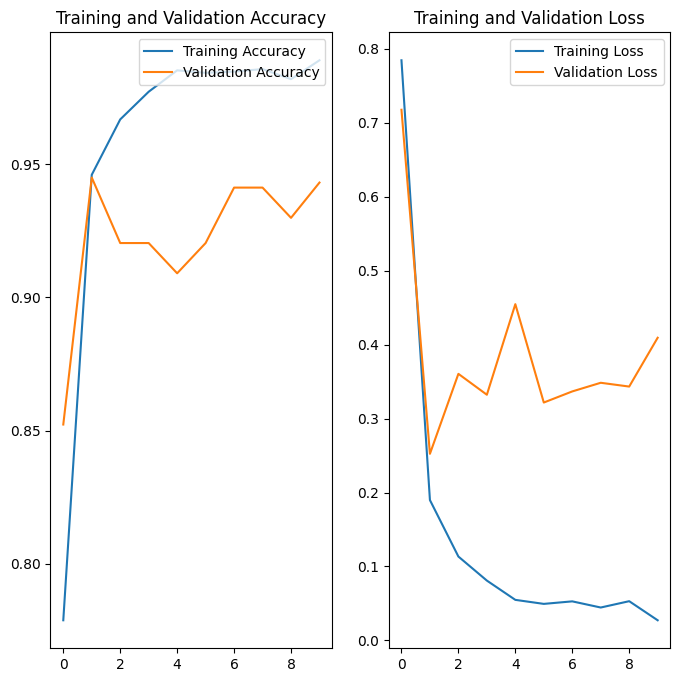

In [8]:
# Step 4: Plot Accuracy and Loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('bestoneyet.h5')

In [22]:
# Step 6: Spot-check and infer

import tensorflow as tf
import numpy as np
import pathlib
import random as rn
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('bestoneyet.h5')

data_dir = './bikes/'

image_size = (224, 224)
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
)

# 1a. Grab Random Motorcycle
class_names = list(train_ds.class_names)
validation_path = pathlib.Path("./bikes/")
valid = list(validation_path.glob('*/*'))
rn_car = rn.randint(0, len(valid))
car = valid[rn_car]

# 1b. Display Actual Motorcycle
print("Actual bike {}".format(car))

# 2. Load Image to Array
image = tf.keras.preprocessing.image.load_img(car, target_size=image_size)
image = tf.keras.preprocessing.image.img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
temp = plt.imread(car)

# 3. Preprocess and Predict
image = tf.keras.applications.resnet50.preprocess_input(image)
predictions = model.predict(image)
# print(predictions)
score = tf.nn.softmax(predictions[0])
print(
  "Prediction: {} with a {:.2f} percent confidence."
  .format(class_names[np.argmax(score)], 100 * np.max(score)))

Found 1409 files belonging to 13 classes.
Using 1128 files for training.
Actual bike bikes\JB_MT10_GREY\A59I6881Canon_EOS-1D_X_Mark_III.jpg
1/1 [==============================] - 1s 829ms/step
Prediction: JB_R1_BLUE with a 13.23 percent confidence.


Actual bike ./data\ADAM_NCBIKE_1314\Canon_EOS_R30314-person.jpg
1/1 [==============================] - 0s 98ms/step
1
Predicted class: ADAM_NCBIKE_1314 with probability 1.00


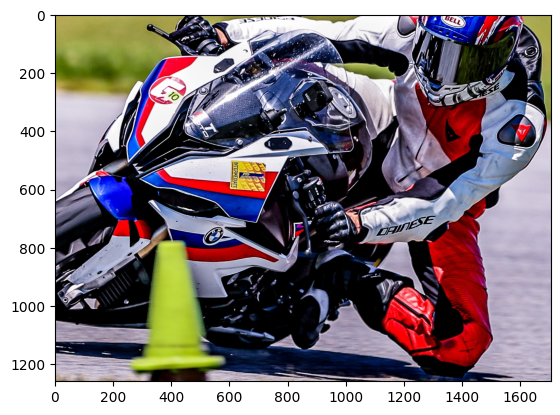

In [151]:
import numpy as np
import glob
from tensorflow.keras.preprocessing import image


files = glob.glob('./data/*/*.jpg', recursive=True)
bike = rn.choice(files)
temp = plt.imread(bike)
plt.imshow(temp)

print("Actual bike {}".format(bike))


def predict(model, img_path):
    # Load the image and preprocess it for the model
    img = image.load_img(img_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # x = x / 255.0
    
    # Perform the prediction
    predictions = model.predict(x)
    
    # Extract the class labels and corresponding probabilities
    class_idx = np.argmax(predictions[0])
    print(class_idx)
    class_label = train_ds.class_names[class_idx]
    class_prob = predictions[0][class_idx]
    
    return class_label, class_prob

class_label, class_prob = predict(model, bike)
print(f'Predicted class: {class_label} with probability {class_prob:.2f}')